# NN model evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
MODEL_CKPT = "../checkpoints/Best/ckpt_last.pt"   # path to your trained checkpoint
TEST_H5    = "../DATA/test.h5"            # path to HDF5 test set with datasets: images, masks
CATALOG_CSV= "../DATA/test.csv"           # path to catalog (injected trails with positions & metadata)

# Detection parameters
THRESHOLD  = 0.50      # binarization threshold for NN probability map
RADIUS_PX  = 3         # pixel radius around (x,y) to accept NN hit

# Tiling parameters (should match training/eval input tiling)
TILE       = 128

In [3]:
import sys
from pathlib import Path
proj = Path("../")
sys.path.insert(0, str(proj))
from torch.utils.data import DataLoader
from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full
from ADCNN.evaluation import pixelwise_roc_from_hist, object_candidates_and_scores, roc_from_scores, pixelwise_confusion, objectwise_confusion_from_candidates, print_confusion_matrix, mark_nn_and_stack_fds, plot_detect_hist
import os, math, numpy as np, torch, h5py, pandas as pd, matplotlib.pyplot as plt

In [6]:
test_ds = H5TiledDataset(TEST_H5, tile=TILE, k_sigma=5.0)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
print("Tiles:", len(test_ds), "| images:", test_ds.N, f"| panel size: {test_ds.H}x{test_ds.W}")
model = load_model(MODEL_CKPT)
p_full = predict_tiles_to_full(TEST_H5, test_loader, model, tile=TILE)
print("Predictions shape:", p_full.shape)

Tiles: 51200 | images: 50 | panel size: 4000x4072
Loaded model from: ../checkpoints/Best/ckpt_last.pt
Predictions shape: (50, 4000, 4072)


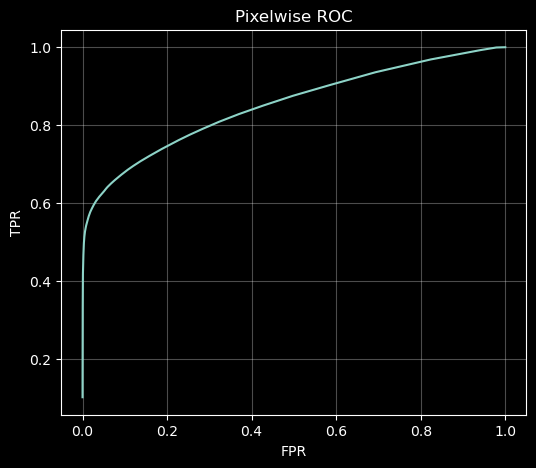

Pixelwise AUC: 0.8516


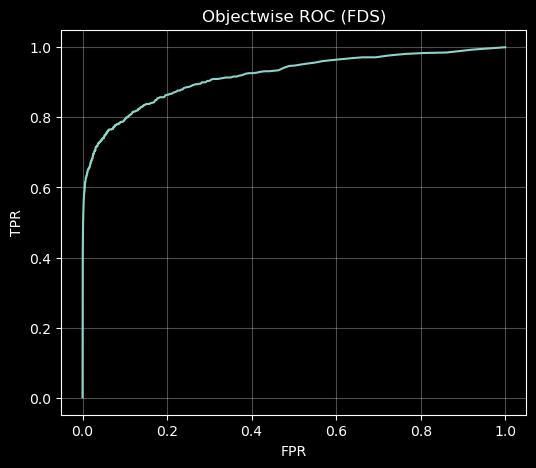

Objectwise AUC: 0.9178
Pixelwise @ thr=0.5


,Pred +,Pred -
Actual +,501236,3142113
Actual -,486179,810270472


Pixelwise: P=0.1376 R=0.5076 F1=0.2165 F2=0.3301
Objectwise @ thr=0.5


,Pred +,Pred -
Actual +,547,2085
Actual -,182,36320


Objectwise: P=0.2078 R=0.7503 F1=0.3255 F2=0.4930


In [7]:
# ---- Load GT masks once ----
with h5py.File(TEST_H5, "r") as _f:
    gt_full = _f["masks"][:].astype(np.uint8)

# ---- Pixelwise ROC ----
fpr_px, tpr_px, thr_px, auc_px = pixelwise_roc_from_hist(p_full, gt_full, nbins=1024)
print(f"Pixelwise AUC: {auc_px:.4f}")

# ---- Objectwise ROC (FDS candidates) ----
base_thr = 0.05
cand_scores, cand_labels = object_candidates_and_scores(p_full, gt_full, base_thr=base_thr, pixel_gap=RADIUS_PX)
fpr_obj, tpr_obj, thr_obj, auc_obj = roc_from_scores(
    pos_scores=cand_scores[cand_labels],
    neg_scores=cand_scores[~cand_labels],
    num_thresh=512
)
plt.figure(figsize=(6,5)); plt.plot(fpr_obj, tpr_obj)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Objectwise ROC (FDS)"); plt.grid(True, alpha=0.3); plt.show()
print(f"Objectwise AUC: {auc_obj:.4f}")

# ---- Confusions + F1/F2 at THRESHOLD ----
cm_px, prf_px = pixelwise_confusion(p_full, gt_full, thr=THRESHOLD)
print_confusion_matrix(cm_px, title=f"Pixelwise @ thr={THRESHOLD}")
prec,rec,f1,f2 = prf_px[0],prf_px[1],prf_px[2],prf_px[3]
print(f"Pixelwise: P={prec:.4f} R={rec:.4f} F1={f1:.4f} F2={f2:.4f}")

cm_obj, prf_obj = objectwise_confusion_from_candidates(cand_scores, cand_labels, thr=THRESHOLD)
print_confusion_matrix(cm_obj, title=f"Objectwise @ thr={THRESHOLD}")
prec,rec,f1,f2 = prf_obj[0],prf_obj[1],prf_obj[2],prf_obj[3]
print(f"Objectwise: P={prec:.4f} R={rec:.4f} F1={f1:.4f} F2={f2:.4f}")


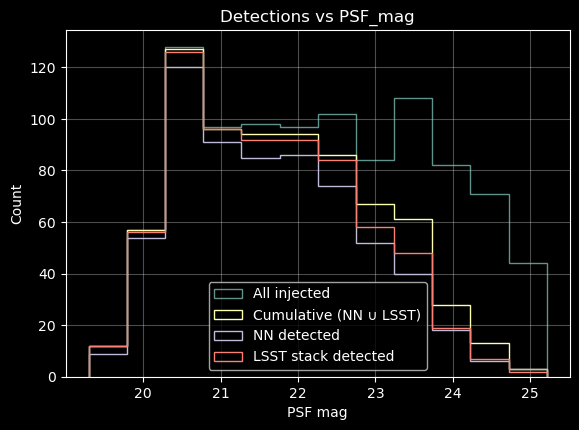

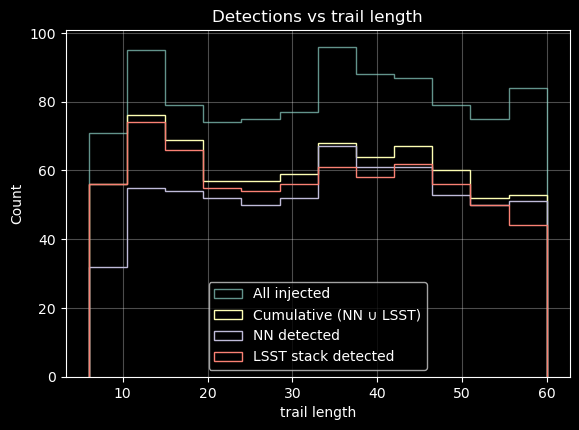

In [10]:
THRESHOLD  = 0.1
cat = mark_nn_and_stack_fds(CATALOG_CSV, p_full, thr=THRESHOLD, pixel_gap=RADIUS_PX, line_width=1)
mag_field = "PSF_mag"
if mag_field is not None:
    _ = plot_detect_hist(cat, mag_field, bins=12, title=f"Detections vs {mag_field}")
else:
    print("No magnitude column found in CSV; skipping magnitude histogram.")

if "trail_length" in cat.columns:
    _ = plot_detect_hist(cat, "trail_length", bins=12, title="Detections vs trail length")
else:
    print("CSV missing 'trail_length'; skipping trail-length histogram.")

plt.show()